<a href="https://colab.research.google.com/github/LastPudding/Text_Mining_LSTM/blob/main/TextMiningCoursework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import spacy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Concatenate, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()
import matplotlib.pyplot as plt
  # Load spaCy English tokenizer
nlp = spacy.load("en_core_web_sm")

In [2]:
!ls
#Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

dev.pointer  dev.tup  relations.txt  test.pointer  test.tup  train.pointer  train.tup
dev.sent     dev.txt  sample_data    test.sent	   test.txt  train.sent     train.txt
Num GPUs Available:  1


# Some util function definition

In [3]:

#Function to extract Annotations of Sentences
def extract_relations(file_path):
  result=[]
  with open(file_path, 'r') as file:
    for each_line in file:
      replaced_string = each_line.replace(' ', '_').replace('/', '_or_').replace('\n', '')
      result.append(replaced_string)
  return result


def extract_triplets(file_path):
  triplets = []
  with open(file_path, 'r') as file:
      for line in file:
          line = line.strip()  # Remove leading/trailing whitespace
          line=line.replace('/', 'or').replace('\n', '')
          if line:  # Check if the line is not empty
              # Split the line into individual triplets using the delimiter "|"
              individual_triplets = line.split('|')
              triplet_list = []
              # Split each individual triplet into entities and relation
              for triplet in individual_triplets:
                  triplet_parts = triplet.strip().split(';')
                  if len(triplet_parts) == 3:
                      subject, related_entity, relation = [part.strip() for part in triplet_parts]
                      triplet_list.append((subject, related_entity, relation))
              triplets.append(triplet_list)
  return triplets

def read_document(file_path):
      with open(file_path, 'r', encoding='utf8') as file:
          lines = [line.strip() for line in file]
      return lines

  # Function to tokenize sentences
def tokenize_sentences(sentences):
      tokenized_sentences = []
      for sentence in sentences:
          tokens = [token.text for token in nlp(sentence)]
          tokenized_sentences.append(tokens)
      return tokenized_sentences

  #Extract position of entities (POE) from .pointer file
def extract_POE(file_path):
      POE_Entities=[]
      with open(file_path, 'r') as file:
          for each_line in file:
            POE_list=each_line.split('|')
            POE_set=set()
            for each_POE in POE_list:
              each_POE=each_POE.strip()

              content=each_POE.split(' ')
              POE_set.add((int(content[0]),int(content[1])))
              POE_set.add((int(content[2]),int(content[3])))
            POE_Entities.append(POE_set)

      return POE_Entities

def mark_positions(sequences,POE_list):
  relative_positions=[[],[],[]]
  if len(sequences)!=len(POE_list):
    print("Length of input do not match!")
    return
  for k in range(0,3):
    for i in range(0,len(sequences)):
      each_sequence=sequences[i]
      each_POE_List=POE_list[i]
      positions=each_sequence
      adding_position=True
      temp_list4set=list(each_POE_List)
      if k>=len(temp_list4set):
        relative_positions[k].append(np.zeros(len(positions)).astype(int).tolist())
      else:
        for j in range(0,len(each_sequence)):
          each_num=each_sequence[j]

          entity1_start=temp_list4set[k][0]
          entity1_end=temp_list4set[k][1]
          if j<entity1_start:
            positions[j]=-entity1_start+j
          elif entity1_start<j<entity1_end:
            positions[j]=0
          elif j>entity1_end and each_num!=0 :
            positions[j]=j-entity1_end
          else:
            positions[j]=0

        relative_positions[k].append(positions)


  return relative_positions[0],relative_positions[1],relative_positions[2]

def count_tokens(sentences, min_count=None):
      token_counts = {}  # Create an empty dictionary to store tokens and their counts

      # Iterate over each sentence
      for sentence in sentences:
          # Iterate over each token in the sentence
          for token in nlp(sentence):
            if str(token) not in ['.',',','(', ')', '-',"%", "'", ':']:
              # Add the token to the dictionary and update the count
              token_counts[str(token)] = token_counts.get(str(token), 0) + 1

      # Filter tokens by minimum count if specified
      if min_count is not None:
          token_counts = {token: count for token, count in token_counts.items() if count > min_count}

      # Sort the dictionary by value (token counts) in descending order
      token_counts = dict(sorted(token_counts.items(), key=lambda x: x[1], reverse=True))

      return token_counts

# Feature Engineering
def convert_to_sequences(sentences, annotations, word_to_index, relations_to_index):
      X = []
      y = []
      for i in range(len(sentences)):
          sentence = sentences[i]
          annotation = annotations[i]
          sequence = []  # Convert sentence to sequence of word indices
          for word in sentence.split():
            if word not in ['.',',','(', ')', '-',"%", "'", ':']:
              if word in word_to_index:
                  sequence.append(word_to_index[word])
              else:
                  sequence.append(0)  # Use 0 for out-of-vocabulary words
          X.append(sequence)
          # Convert annotation to multi-class label
          label = np.zeros(len(relations_to_index)).tolist()  # Initialize with zeros for all classes
          for each_tup in annotation:
            label[relations_to_index[each_tup[2]]] = 1.0  # Set the corresponding index to 1

          y.append(label)
      return X, np.array(y)

def f1_score(y_true, y_pred):
  # if y_true.shape!=y_pred.shape:
  #   return -1
  y_true=y_true.tolist()
  y_pred=y_pred.numpy().tolist()

  TP=0.0
  TN=0.0
  FP=0.0
  FN=0.0
  for i,each_prediction in enumerate(y_true):
    for j,each_digit in enumerate(each_prediction):
      if y_true[i][j]==1. and y_pred[i][j]==1:
        TP+=1.0
      elif y_true[i][j]==0. and y_pred[i][j]==0:
        TN+=1.0
      elif y_true[i][j]==1. and y_pred[i][j]==0:
        FN+=1.0
      elif y_true[i][j]==0. and y_pred[i][j]==1:
        FP+=1.0
  print(TP,TN,FP,FN)
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  f_score=2*precision*recall/(precision+recall)
  return f_score

# Data Preprocessing

##Extracts Position of entity from *.pointer file, used for position-embedding models

In [4]:
train_POE_list=extract_POE('train.pointer')
test_POE_list=extract_POE('test.pointer')

In [5]:
# count=0
# for each_set in test:
#   if len(each_set)>3:
#     count+=1
# print(count)

## Extracts sentences and annotation from file, and set up relation to index mapping

In [6]:

  # Extracting sentences and Triplets
train_annotations, test_annotations = extract_triplets('train.tup'), extract_triplets('test.tup')
train_sentences, test_sentences = read_document('train.sent'), read_document('test.sent')
val_sentences, val_annotations = read_document('dev.sent'), extract_triplets('dev.tup')
  # Read unique relations from relations.txt
relations = extract_relations('relations.txt')
unique_relations={}
for relation in relations:
          doc = nlp(relation)
          tokens = [token.text for token in doc]
          unique_relations[relation] = tokens

num_unique_relations = len(unique_relations)

  #Create a mapping between each relation and its index
relation_to_index = {relation.replace(" ", "_").replace('/', '_or_').replace('\n', ''): index for index, relation in enumerate(unique_relations)}
print(relation_to_index)

{'product_or_material_produced': 0, 'manufacturer': 1, 'distributed_by': 2, 'industry': 3, 'position_held': 4, 'original_broadcaster': 5, 'owned_by': 6, 'founded_by': 7, 'distribution_format': 8, 'headquarters_location': 9, 'stock_exchange': 10, 'currency': 11, 'parent_organization': 12, 'chief_executive_officer': 13, 'director_or_manager': 14, 'owner_of': 15, 'operator': 16, 'member_of': 17, 'employer': 18, 'chairperson': 19, 'platform': 20, 'subsidiary': 21, 'legal_form': 22, 'publisher': 23, 'developer': 24, 'brand': 25, 'business_division': 26, 'location_of_formation': 27, 'creator': 28}


## number of samples with increasing number of relations

In [7]:
# Analysis on training set
# for i in range(1,39):
#   count=0
#   for each_label in train_annotations:
#     if len(each_label)>i:
#       count+=1
#   print("There are {} samples with {} relation(s)".format(count,i))

## Data filtering

Removing samples from training set that comes with too many relations within a single sample

In [8]:
too_much_relations = [i for i, each_label in enumerate(train_annotations) if  len(each_label)>3]

# train_annotations = [num for i, num in enumerate(train_annotations) if i not in too_much_relations]
# train_sentences = [num for i, num in enumerate(train_sentences) if i not in too_much_relations]


## Finalize and generate word to index mapping

In [9]:
FILTER_MIN=1

  # Build vocabulary
vocabulary = count_tokens(train_sentences)
print(vocabulary)
filtered_vocabulary = {key: value for key, value in vocabulary.items() if value > FILTER_MIN}

  # Print filtered vocabulary
print(filtered_vocabulary)
  # Create word_to_index mapping
word_to_index = {word: index for index, (word, count) in enumerate(filtered_vocabulary.items(), start=1)}
print(word_to_index)

{'the': 7877, 'and': 5221, 'of': 4664, 'to': 4621, 'in': 4035, 'a': 3490, 'on': 1851, 'for': 1794, 'that': 1486, 'news': 1399, 'with': 1369, 'is': 1308, 'as': 1272, "'s": 1229, 'its': 1100, 'at': 956, 'by': 954, 'said': 897, 'from': 874, '"': 873, 'has': 860, 'it': 793, 'The': 778, 'Group': 757, 'LSE': 718, '$': 716, 'will': 710, 'company': 624, 'an': 604, 'was': 562, 'which': 560, 'we': 551, 'are': 530, '’s': 516, 'have': 510, 'year': 489, 'our': 486, 'be': 485, 'new': 459, 'more': 436, 'after': 424, 'this': 410, 'billion': 390, 'Other': 369, 'Bank': 365, '2015': 358, 'up': 352, 'or': 338, 'million': 331, 'their': 330, ';': 323, 'market': 319, 'percent': 318, 'than': 310, 'business': 309, 'also': 304, 'would': 290, 'OTC': 280, 'his': 279, 'not': 279, 'over': 271, 'Reuters': 268, 'been': 262, 'India': 261, 'I': 258, 'CEO': 254, 'had': 252, 'retail': 248, 'but': 247, 'other': 244, 'including': 242, 'all': 240, '”': 240, 'about': 237, 'Inc.': 235, 'you': 234, 'first': 234, '“': 234, 'one

# Feature engineering (most of them), and some graphs about it

In [10]:
  # Convert training data to sequences
X_train, y_train = convert_to_sequences(train_sentences, train_annotations, word_to_index, relation_to_index)

X_val,y_val=convert_to_sequences(val_sentences, val_annotations, word_to_index, relation_to_index)
  # Convert testing data to sequences
X_test, y_test = convert_to_sequences(test_sentences, test_annotations, word_to_index, relation_to_index)



# Hyperparameters
EMBEDDING_DIM = 300  # Dimension of word embeddings
NUM_CLASSES = num_unique_relations  # Number of classes for relation extraction
BATCH_SIZE = 128
EPOCHS = 14
MAX_SEQ_LENGTH = 100#max(len(sentence) for sentence in X_train)
VOCABULARY_SIZE=len(word_to_index) + 1



## Statistical analysis of sequence length

In [11]:
import statistics
import matplotlib.pyplot as plt
from collections import Counter
def statistical_analysis(dataset):
  seq_length_list=[len(num) for i,num in enumerate(dataset)]
  print(len(seq_length_list))
  avg= sum(seq_length_list)/len(seq_length_list)
  print("average sequence length:",avg)
  minimum=min(seq_length_list)
  maximum=max(seq_length_list)
  print("Minumun:",minimum,"; Maximum:",maximum)
  standard_deviation=(sum([(num-avg)**2 for i,num in enumerate(seq_length_list)])/len(seq_length_list))**0.5
  print("Standard deviation:",standard_deviation)
  median=statistics.median(seq_length_list)
  print("Median:",median)


In [12]:
statistical_analysis(X_train)

5700
average sequence length: 35.44701754385965
Minumun: 2 ; Maximum: 907
Standard deviation: 32.09479653758791
Median: 31.0


## Graphs about Distribution of sequence length

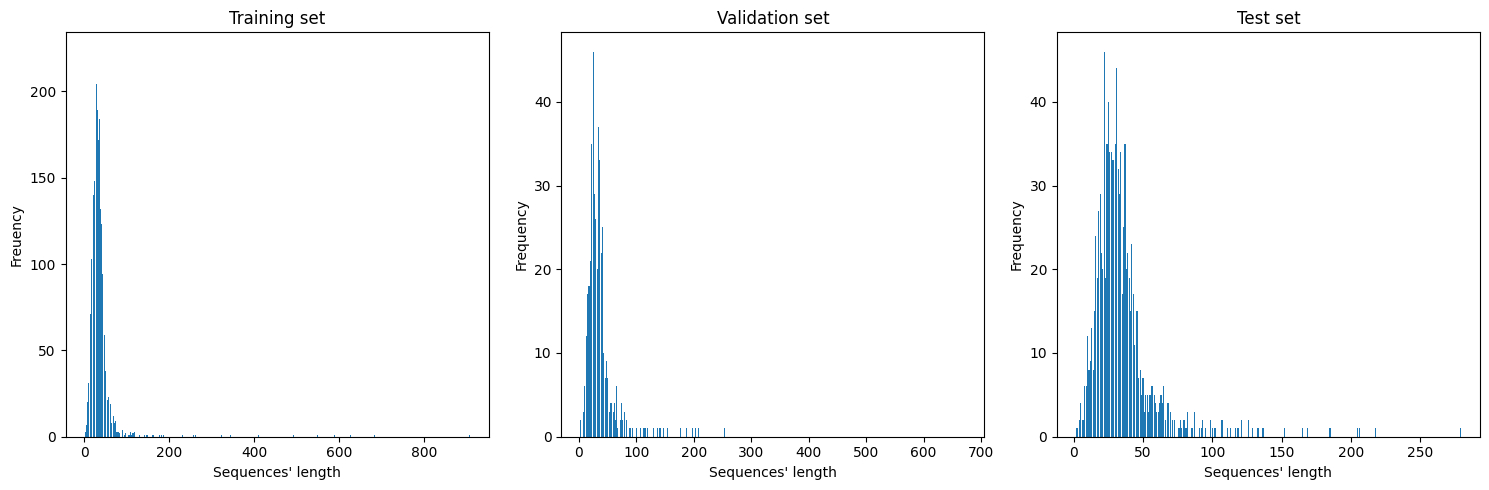

In [13]:

counter1 = Counter([len(num) for i,num in enumerate(X_train)])
counter2 = Counter([len(num) for i,num in enumerate(X_val)])
counter3 = Counter([len(num) for i,num in enumerate(X_test)])

x_values1 = list(counter1.keys())
y_values1 = list(counter1.values())

x_values2 = list(counter2.keys())
y_values2 = list(counter2.values())

x_values3 = list(counter3.keys())
y_values3 = list(counter3.values())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(x_values1, y_values1)
plt.xlabel('Sequences\' length')
plt.ylabel('Freuency')
plt.title('Training set')

plt.subplot(1, 3, 2)
plt.bar(x_values2, y_values2)
plt.xlabel('Sequences\' length')
plt.ylabel('Frequency')
plt.title('Validation set')

plt.subplot(1, 3, 3)
plt.bar(x_values3, y_values3)
plt.xlabel('Sequences\' length')
plt.ylabel('Frequency')
plt.title('Test set')

plt.tight_layout()

plt.show()

## Some treatment to data to generate a pie chart(Not used at the moment)

They don't look nice so currently I transfered the proportion data to excel and generate pie charts there

In [14]:
relations_distribution=np.zeros(38)
for each_anno in train_annotations:
  relations_distribution[len(each_anno)]+=1
relation_plot_labels=[]
relation_plot_nums=[]
for i,each_num in enumerate(relations_distribution):
  if each_num!=0:
    relation_plot_nums.append(each_num/sum(relations_distribution.tolist()))
    relation_plot_labels.append(str(i))
relation_plot_nums=relation_plot_nums[:4]+[sum(relation_plot_nums[4:])]
relation_plot_labels=relation_plot_labels[:4]+[">4"]

relations_distribution_val=np.zeros(38)
for each_anno in val_annotations:
  relations_distribution_val[len(each_anno)]+=1
relation_plot_nums_val=[]
relation_plot_labels_val=[]
for i,each_num in enumerate(relations_distribution_val):
  if each_num!=0:
    relation_plot_nums_val.append(each_num/sum(relations_distribution_val.tolist()))
    relation_plot_labels_val.append(str(i))
relation_plot_nums_val=relation_plot_nums_val[:4]+[sum(relation_plot_nums_val[4:])]
relation_plot_labels_val=relation_plot_labels_val[:4]+[">4"]

relations_distribution_test=np.zeros(38)
for each_anno in test_annotations:
  relations_distribution_test[len(each_anno)]+=1
relation_plot_nums_test=[]
relation_plot_labels_test=[]
for i,each_num in enumerate(relations_distribution_test):
  if each_num!=0:
    relation_plot_nums_test.append(each_num/sum(relations_distribution_test.tolist()))
    relation_plot_labels_test.append(str(i))
relation_plot_nums_test=relation_plot_nums_test[:4]+[sum(relation_plot_nums_test[4:])]
relation_plot_labels_test=relation_plot_labels_test[:4]+[">4"]

print(relation_plot_labels_test)
print(relation_plot_nums_test)

['1', '2', '3', '4', '>4']
[0.7256554307116105, 0.18352059925093633, 0.06273408239700375, 0.028089887640449437, 0]


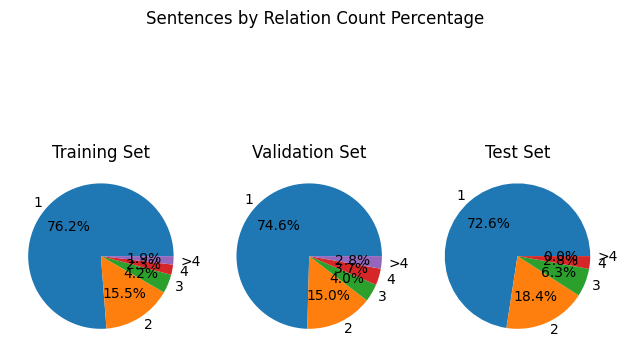

In [15]:
fig, axs = plt.subplots(1, 3)

axs[0].pie(relation_plot_nums, labels=relation_plot_labels, autopct='%1.1f%%')
axs[0].set_title('Training Set')

axs[1].pie(relation_plot_nums_val, labels=relation_plot_labels_val, autopct='%1.1f%%')
axs[1].set_title('Validation Set')

axs[2].pie(relation_plot_nums_test, labels=relation_plot_labels_test, autopct='%1.1f%%')
axs[2].set_title('Test Set')

plt.suptitle('Sentences by Relation Count Percentage')

plt.tight_layout()

plt.show()

In [16]:
too_long_sequence = [i for i, each_label in enumerate(X_train) if  len(each_label)>100]
indice_to_remove=list(set(too_long_sequence).union(set(too_much_relations)))

X_train = [num for i, num in enumerate(X_train) if i not in indice_to_remove]
y_train = np.array([num.tolist() for i, num in enumerate(y_train) if i not in indice_to_remove])

def remove_lines(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # 根据索引去除指定行
    filtered_lines = [line for i, line in enumerate(lines) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(filtered_lines)

# 用法示例
input_file = 'train.txt'  # 源文件名
output_file = 'train_reduced.txt'  # 输出文件名

remove_lines(input_file, output_file, indice_to_remove)


In [17]:

# Padding sequences to ensure uniform length
X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH)
X_val = pad_sequences(X_val, maxlen=MAX_SEQ_LENGTH)

In [18]:

for i in range(1,10):
  count=0
  for each_label in y_train:
    if sum(each_label)>i:
      count+=1
  print(count)


963
172
0
0
0
0
0
0
0


In [19]:
# indices = [i for i, each_label in enumerate(y_train) if  sum(each_label)>3]

# print(indices)

# X_train_reduced = np.array([num for i, num in enumerate(X_train.tolist()) if i not in indices])

# y_train_reduced = np.array([num for i, num in enumerate(y_train.tolist()) if i not in indices])

# print(len(X_train_reduced)==len(y_train_reduced))
# print([i for i, num in enumerate(X_train_reduced) if len(num)!=907])
# print([i for i, num in enumerate(y_train_reduced) if len(num)!=29])

# Trainer Definition

In [24]:
def train_model(X_train, y_train,batch_size=8,epoch=6,num_NN=128,dropout=0.6,is_saving=False,saving_acc=0.55,num_Dense=64):
  history_callback = tf.keras.callbacks.History()
  optimizer = tf.keras.optimizers.Adam()
  model = Sequential()
  model.add(Embedding(VOCABULARY_SIZE, output_dim=EMBEDDING_DIM, input_shape=(MAX_SEQ_LENGTH,)))
  # model.add(Bidirectional(LSTM(num_NN,dropout=dropout,return_sequences=True)))
  model.add(Bidirectional(LSTM(num_NN,dropout=dropout)))
  model.add(Dense(num_Dense, activation='relu'))

  model.add(Dense(NUM_CLASSES, activation='softmax'))

        # Compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

      # Train model
  if is_saving:
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch, validation_data=(X_val, y_val),callbacks=[history_callback])
  else:
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch, validation_data=(X_val, y_val))
  if is_saving:
    history = history_callback.history
    best_accuracy = np.max(history['val_acc'])
    if best_accuracy>saving_acc:
      tf.saved_model.save(model, './batch_size={};epoch={};num_NN={};num_Dense={}'.format(batch_size,epoch,num_NN,num_Dense))





## Trainer Usage

In [20]:
indice_for_relation=np.empty((29, 1)).tolist()
print(indice_for_relation)
for i,each_sample in enumerate(y_train):
  for j,each_class in enumerate(each_sample):
    if each_class==1:
      indice_for_relation[j].append(i)
for i,each_line in enumerate(indice_for_relation):
  indice_for_relation[i]=each_line[1:]
print(indice_for_relation)

[[0.0], [3.787762486875e-311], [9.87e-321], [5.4e-323], [8.487983164e-314], [6.4232812608294e-311], [2.5e-323], [5.5596289738e-312], [1.659400708535e-311], [0.0], [5.597824896721e-311], [4.96547015086e-312], [2.4190752026283e-311], [1.788842453087e-311], [2.1219957924e-314], [3.9851080955484e-311], [0.0], [3.7877624868864e-311], [7.320885480377e-312], [6.7755325605536e-311], [9.87e-321], [2.1219957964e-314], [0.0], [6.775532560554e-311], [3.3951933757e-313], [6.32354745708e-312], [5.70816867821e-312], [6.32354746835e-312], [9.7611807235e-313]]
[[2, 10, 12, 18, 27, 31, 32, 34, 37, 48, 49, 53, 62, 63, 64, 65, 66, 68, 70, 71, 76, 95, 97, 98, 99, 115, 116, 118, 120, 125, 126, 130, 131, 132, 135, 140, 144, 149, 152, 153, 171, 173, 177, 178, 185, 186, 187, 188, 208, 230, 231, 248, 249, 253, 262, 263, 265, 266, 272, 273, 278, 280, 281, 287, 291, 292, 293, 294, 295, 296, 297, 298, 303, 309, 313, 320, 321, 330, 331, 333, 334, 342, 345, 346, 348, 351, 353, 355, 360, 364, 365, 369, 380, 381, 390,

In [21]:
import random

def increase_to_value(arr, target_value):
    while len(arr) < target_value:
        random_element = random.choice(arr)
        arr.append(random_element)
    return arr


In [22]:
max_len=0
for each_indice in indice_for_relation:
  if len(each_indice)>max_len:
    max_len=len(each_indice)

for i,each_indice in enumerate(indice_for_relation):
  indice_for_relation[i]=increase_to_value(each_indice,max_len)

indice_for_relation=np.array(indice_for_relation)
indice_for_relation=indice_for_relation.flatten()
np.random.seed(42)
np.random.shuffle(indice_for_relation)
X_train_augumented=[]
y_train_augumented=[]
for each_indice in indice_for_relation:
  X_train_augumented.append(X_train[each_indice])
  y_train_augumented.append(y_train[each_indice])
X_train_augumented=np.array(X_train_augumented)
y_train_augumented=np.array(y_train_augumented)

In [56]:
train_model(X_train_augumented, y_train_augumented,batch_size=32,epoch=20,num_NN=384,dropout=0.85,num_Dense=128,is_saving=True,saving_acc=0.50)

Epoch 1/20
1109/1109 [==============================] - 37s 30ms/step - loss: 0.1388 - acc: 0.2935 - val_loss: 0.1566 - val_acc: 0.2393
Epoch 2/20
1109/1109 [==============================] - 18s 16ms/step - loss: 0.0441 - acc: 0.6488 - val_loss: 0.1552 - val_acc: 0.3366
Epoch 3/20
1109/1109 [==============================] - 17s 16ms/step - loss: 0.0221 - acc: 0.7275 - val_loss: 0.1614 - val_acc: 0.4389
Epoch 4/20
1109/1109 [==============================] - 17s 15ms/step - loss: 0.0132 - acc: 0.7681 - val_loss: 0.1606 - val_acc: 0.5204
Epoch 5/20
1109/1109 [==============================] - 16s 15ms/step - loss: 0.0090 - acc: 0.8009 - val_loss: 0.1596 - val_acc: 0.5273
Epoch 6/20
1109/1109 [==============================] - 17s 15ms/step - loss: 0.0061 - acc: 0.8140 - val_loss: 0.1763 - val_acc: 0.5333
Epoch 7/20
1109/1109 [==============================] - 17s 15ms/step - loss: 0.0048 - acc: 0.8167 - val_loss: 0.1887 - val_acc: 0.5521
Epoch 8/20
1109/1109 [==========================

# Predicter definition

**Model Predicter**

---


Given a sequence of sentence(s), word and relation to index mapping and maximum sequence length if not uning FINRed, returns a sequence of prediction. Paremeters with defaults can be safely left as blank when the model used the training set from FINRed, but otherwise must be configured as identical to those are used during training.


---
**model:** a model extracted by **tf.saved_model.load**, note that freshly trained model can't be fed into the function in this way, as the model recreated from save is different than fresh ones and therefore having different usage


---
**X:** a 1-dimension sequence of sentences to predict. No need for any vector conversion in advance, these are done within the function


---

**word_to_index,relation_to_index:** key-value pairs that maps word/relation to integers. These must be identical to those are used during the training. The relation to index sequence is flipped in the function for its reversed use to convert integer back to label.


---
**MAX_SEQ_LENGTH:** the maxima sequence length encountered during training, must be identical to the one used when training.




In [26]:
def predict_with_model(model,X,word_to_index='default',relation_to_index='default',MAX_SEQ_LENGTH=100,return_sequences=False):#uning FINRed by default, the MAX_SEQ_LENGTH is 589

  if word_to_index=='default':
    pass
  if relation_to_index=='default':
    relation_to_index={'product_or_material_produced': 0, 'manufacturer': 1, 'distributed_by': 2, 'industry': 3, 'position_held': 4, 'original_broadcaster': 5, 'owned_by': 6, 'founded_by': 7, 'distribution_format': 8, 'headquarters_location': 9, 'stock_exchange': 10, 'currency': 11, 'parent_organization': 12, 'chief_executive_officer': 13, 'director_or_manager': 14, 'owner_of': 15, 'operator': 16, 'member_of': 17, 'employer': 18, 'chairperson': 19, 'platform': 20, 'subsidiary': 21, 'legal_form': 22, 'publisher': 23, 'developer': 24, 'brand': 25, 'business_division': 26, 'location_of_formation': 27, 'creator': 28}

  flipped_relation = {value: key for key, value in relation_to_index.items()} #flip the relation_to_index for searching by index
  X_seq=[]
  if len(X)>0 and type(X[0])==str:
      for i in range(len(X)):
        sentence = str(X[i])
        sequence = []  # Convert sentence to sequence of word indices
        for word in sentence.split():
          if word not in ['.',',','(', ')', '-',"%", "'", ':']:
            if word in word_to_index:
                sequence.append(word_to_index[word])
            else:
                sequence.append(0)  # Use 0 for out-of-vocabulary words
        X_seq.append(sequence)
      X_seq = pad_sequences(X_seq, maxlen=MAX_SEQ_LENGTH)
      X_seq = tf.cast(X_seq, tf.float32)
  elif len(X)>0:
    X_seq=tf.cast(X, tf.float32)
  else:
    return

  y=model(X_seq)

  threshold = 0.5
  y = tf.where(y > threshold, 1, 0)
  if return_sequences==True:
    return y
  result=[]
  for each_prediction in y:
    for i,digit in enumerate(each_prediction):
      if digit==1:
        result.append(flipped_relation[i])

  return result


## Predictor usage

In [57]:
model= tf.saved_model.load('./batch_size=32;epoch=20;num_NN=384;num_Dense=128')

X=X_test
print(X)
result = predict_with_model(model,X,word_to_index=word_to_index,return_sequences=True)
print(result)

[[   0    0    0 ...    1 1534    0]
 [   0    0    0 ...    0    2    0]
 [   0    0    0 ...    5    6    0]
 ...
 [   0    0    0 ...  260 1318    0]
 [   0    0    0 ... 1159    0    0]
 [   0    0    0 ...  331    5    0]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(1068, 29), dtype=int32)


In [41]:


print(y_test[:1])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0.]]


[0.53909465 0.29090909 0.5        0.57077626 0.35294118 0.28571429
 0.26923077 0.26666667 0.6        0.42       0.5        0.6
 0.29078014 0.2        0.09090909 0.45901639 0.44444444 0.36363636
 0.54736842 0.78947368 0.5        0.33980583 0.18181818 0.28571429
 0.50980392 0.3        0.7        0.22727273 0.42857143]


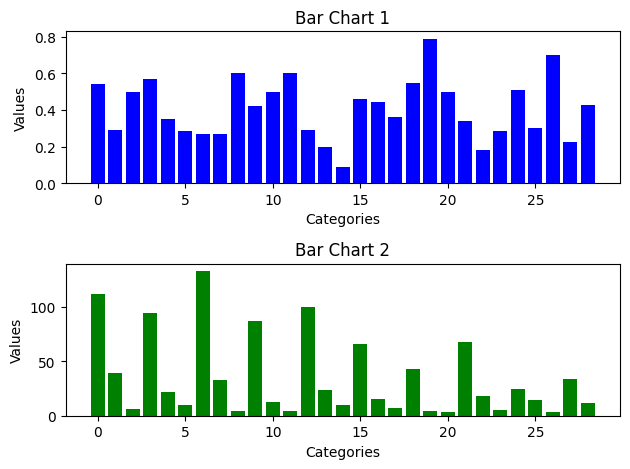

In [42]:
result
def generate_plot(y_pred,y_true):

  predictions_correct = np.zeros([29])
  predictions_wrong = np.zeros([29])
  for i,each_prediction in enumerate(y_true):
    for j,each_digit in enumerate(each_prediction):
      if y_true[i][j]==1 and y_pred[i][j]==1:
        predictions_correct[j]+=1
      elif y_true[i][j]!=y_pred[i][j]:
        predictions_wrong[j]+=1.0
  # 数据

  acc=predictions_correct/(predictions_wrong+predictions_correct)
  print(acc)
  categories = range(0,29)
  values1 = acc  # 第一张图的数据
  values2 = predictions_wrong  # 第二张图的数据

  # 绘制第一张条形图
  plt.subplot(2, 1, 1)  # 2行1列，第1张图
  plt.bar(categories, values1, color='blue')
  plt.title('Bar Chart 1')
  plt.xlabel('Categories')
  plt.ylabel('Values')

  # 绘制第二张条形图
  plt.subplot(2, 1, 2)  # 2行1列，第2张图
  plt.bar(categories, values2, color='green')
  plt.title('Bar Chart 2')
  plt.xlabel('Categories')
  plt.ylabel('Values')

  # 调整布局
  plt.tight_layout()

  # 显示图形
  plt.show()

generate_plot(result,y_test)

In [58]:
f1_score(y_test,result)

749.0 29232.0 304.0 687.0


0.6018481317798312

In [60]:
X_train_pos1,X_train_pos2,X_train_pos3=mark_positions(X_train,train_POE_list)
X_test_pos1,X_test_pos2,X_test_pos3=mark_positions(X_test,test_POE_list)

Length of input do not match!


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
  # Padding sequences to ensure uniform length
X_train_pos1 = pad_sequences(X_train_pos1, maxlen=MAX_SEQ_LENGTH)
X_train_pos2 = pad_sequences(X_train_pos2, maxlen=MAX_SEQ_LENGTH)
X_train_pos3 = pad_sequences(X_train_pos3, maxlen=MAX_SEQ_LENGTH)

X_test_pos1 = pad_sequences(X_test_pos1, maxlen=MAX_SEQ_LENGTH)
X_test_pos2 = pad_sequences(X_test_pos2, maxlen=MAX_SEQ_LENGTH)
X_test_pos3 = pad_sequences(X_test_pos3, maxlen=MAX_SEQ_LENGTH)



In [59]:

X_train_pos1_augumented=[]

for each_indice in indice_for_relation:
  X_train_pos1_augumented.append(X_train_pos1[each_indice])
X_train_augumented=np.array(X_train_augumented)



NameError: name 'X_train_pos1' is not defined

In [ ]:
#Define Bi-LSTM model with position embedding
optimizer = tf.keras.optimizers.Adam()

#https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-2-52086246c66
embed_layer = Embedding(VOCABULARY_SIZE, EMBEDDING_DIM)
input_seq = Input(shape=(MAX_SEQ_LENGTH,))
embed_seq = embed_layer(input_seq)

input_seq_pos1 = Input(shape=(X_train_pos1.shape[1],))
embed_seq_pos1 = Embedding(MAX_SEQ_LENGTH,EMBEDDING_DIM,input_length=MAX_SEQ_LENGTH,trainable=True)(input_seq_pos1)
# input_seq_pos2 = Input(shape=(X_train_pos2.shape[1],))
# embed_seq_pos2 = Embedding(MAX_SEQ_LENGTH,EMBEDDING_DIM,input_length=MAX_SEQ_LENGTH,trainable=True)(input_seq_pos2)
# input_seq_pos3 = Input(shape=(X_train_pos3.shape[1],))
# embed_seq_pos3 = Embedding(MAX_SEQ_LENGTH,EMBEDDING_DIM,input_length=MAX_SEQ_LENGTH,trainable=True)(input_seq_pos2)



# x = tf.concat([embed_seq,embed_seq_pos1, embed_seq_pos2,embed_seq_pos3],1)
x = tf.concat([embed_seq,embed_seq_pos1],1)
x = Bidirectional(LSTM(128,dropout=0.7))(x)
preds = Dense(NUM_CLASSES,activation="softmax")(x)
# model = Model(inputs=[input_seq,input_seq_pos1,input_seq_pos2,input_seq_pos3], outputs=preds)
model = Model(inputs=[input_seq,input_seq_pos1], outputs=preds)

  # Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 907)]                0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 907)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 907, 300)             3568500   ['input_4[0][0]']             
                                                                                                  
 embedding_4 (Embedding)     (None, 907, 300)             272100    ['input_5[0][0]']             
                                                                                            

In [ ]:

# Train model

model.fit([X_train, X_train_pos1], y_train, batch_size=4, epochs=5, validation_data=([X_test,X_test_pos1], y_test))



Epoch 1/5
1425/1425 [==============================] - 175s 121ms/step - loss: 0.1649 - accuracy: 0.2098 - val_loss: 0.1685 - val_accuracy: 0.1695
Epoch 2/5
1425/1425 [==============================] - 150s 105ms/step - loss: 0.1601 - accuracy: 0.2146 - val_loss: 0.1675 - val_accuracy: 0.1695
Epoch 3/5
1425/1425 [==============================] - 148s 104ms/step - loss: 0.1600 - accuracy: 0.2070 - val_loss: 0.1686 - val_accuracy: 0.1695
Epoch 4/5
1425/1425 [==============================] - 145s 102ms/step - loss: 0.1592 - accuracy: 0.2075 - val_loss: 0.1660 - val_accuracy: 0.1498
Epoch 5/5
1425/1425 [==============================] - 148s 104ms/step - loss: 0.1584 - accuracy: 0.2137 - val_loss: 0.1682 - val_accuracy: 0.1760


In [ ]:
# #Define LSTM model
# def grid_search(batch_size,epochs,dropout):
#   optimizer = tf.keras.optimizers.Adam()
#   model = Sequential()
#   model.add(Embedding(len(word_to_index) + 1, output_dim=EMBEDDING_DIM, input_shape=(MAX_SEQ_LENGTH,)))
#   model.add(Bidirectional(LSTM(128, dropout=dropout)))
#   model.add(Dense(64, activation='relu'))

#   model.add(Dense(NUM_CLASSES, activation='softmax'))

#     # Compile model
#   model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#   # Train model

#   model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# batch_size_list=[2,8,16,64]
# epochs=6
# dropout_list=[0,0.2,0.4,0.6,0.8]

# for each_batch_size in batch_size_list:
#   for each_dropout in dropout_list:
#     print("batch size: {}\ndropout: {}".format(each_batch_size,each_dropout))
#     grid_search(each_batch_size,epochs,each_dropout)


In [ ]:
y_test_predicted=model.predict(X_test)
y_test_predicted = tf.convert_to_tensor(y_test_predicted)
loss = tf.keras.losses.categorical_crossentropy(y_test, y_test_predicted)

In [ ]:
X_train